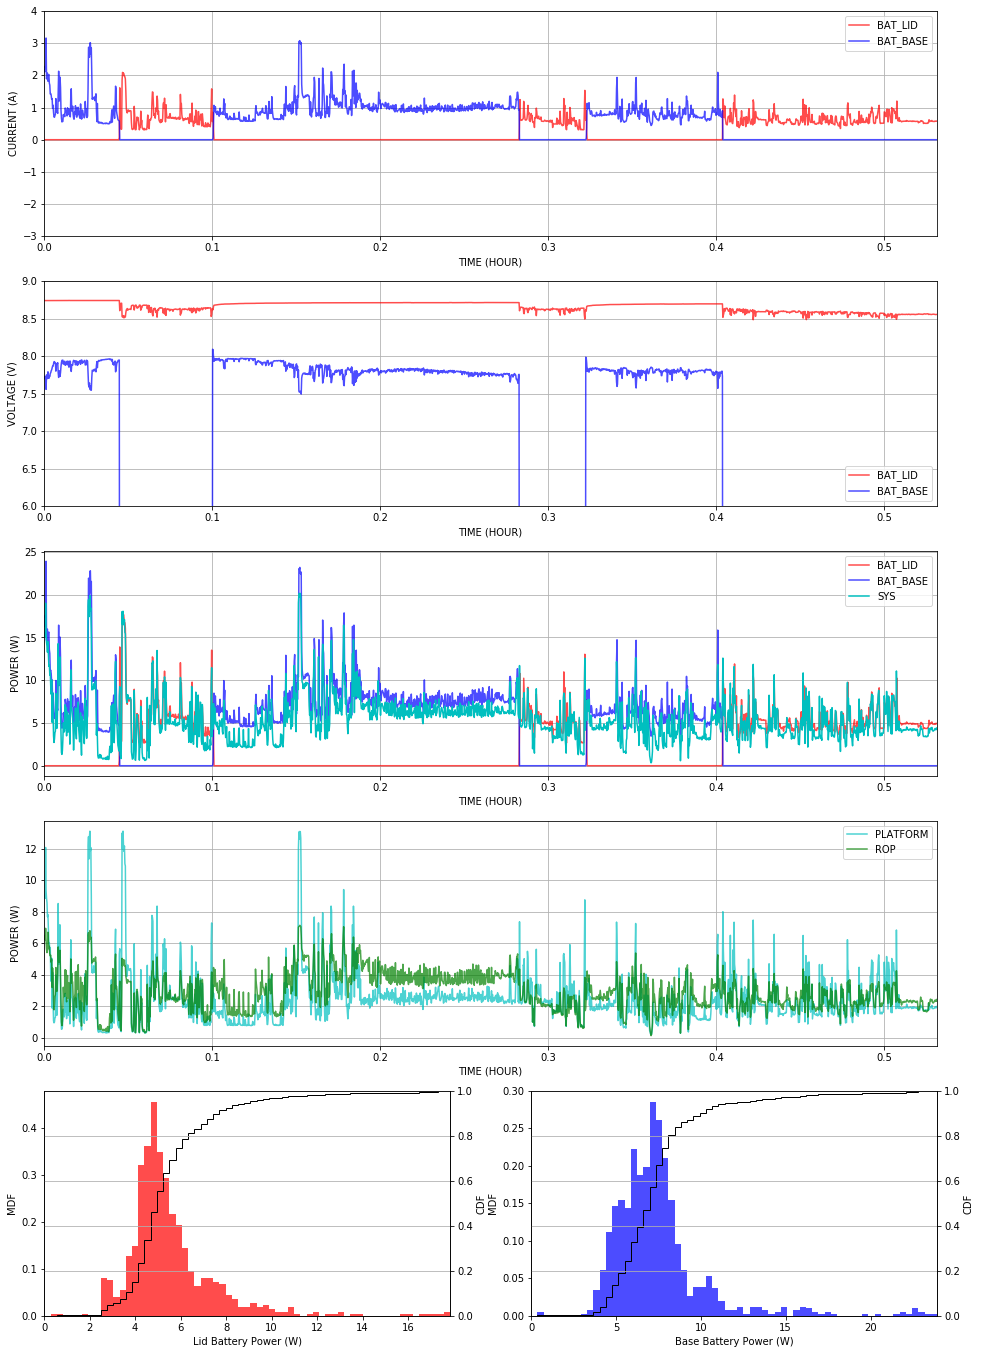

In [7]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.plotly as py   ## <===Plotly!

%matplotlib inline

DUAL_BAT = True

def uj2w(t,e):
    w = [(e[1]-e[0])/(t[1]-t[0])/1e6]
    for t0,t1,e0,e1 in zip(t[:-1],t[1:],e[:-1],e[1:]):
        p = (e1-e0)/(t1-t0)/1e6
        if p>100 or p<-100:
            p=0
        w.append(p)
    return np.array(w)

PLOT_ALPHA=0.7
#df = pd.read_csv('/tmp/mon.csv')
df = pd.read_csv('lux.csv')

cpu_w = uj2w(df['time'],df['cpu_uj'])
sys_w = uj2w(df['time'],df['sys_uj'])*2

#t = df['time']
t = np.arange(len(df['time'])).astype(float)
t = (t - t[0])/60/60

fig=plt.figure(0,figsize=(16,24),facecolor='white')
ax=[]
ax.append( plt.subplot2grid((5, 2), (0, 0), rowspan=1, colspan=2) )
ax.append( plt.subplot2grid((5, 2), (1, 0), rowspan=1, colspan=2) )
ax.append( plt.subplot2grid((5, 2), (2, 0), rowspan=1, colspan=2) )
ax.append( plt.subplot2grid((5, 2), (3, 0), rowspan=1, colspan=2) )
ax.append( plt.subplot2grid((5, 2), (4, 0), rowspan=1, colspan=1) )
ax.append( plt.subplot2grid((5, 2), (4, 1), rowspan=1, colspan=1) )

p=0
ax[p].plot(t, df["i0"]/1e6, 'r', label='BAT_LID', alpha=PLOT_ALPHA)
if DUAL_BAT:
    ax[p].plot(t, df["i1"]/1e6, 'b', label='BAT_BASE', alpha=PLOT_ALPHA)
ax[p].set_ylim([-3,4])

p=1
ax[p].plot(t, df["v0"]/1e6, 'r', label='BAT_LID', alpha=PLOT_ALPHA)
if DUAL_BAT:
    ax[p].plot(t, df["v1"]/1e6, 'b', label='BAT_BASE', alpha=PLOT_ALPHA)
ax[p].set_ylim([6,9])

p=2
ax[p].plot(t, df["i0"]*df["v0"]/1e12, 'r', label='BAT_LID', alpha=PLOT_ALPHA)
if DUAL_BAT:
    ax[p].plot(t, df["i1"]*df["v1"]/1e12, 'b', label='BAT_BASE', alpha=PLOT_ALPHA)
ax[p].plot(t, sys_w, 'c', label='SYS')

p=3
ax[p].plot(t, cpu_w, 'c', label='PLATFORM', alpha=PLOT_ALPHA)
ax[p].plot(t, sys_w - cpu_w, 'g', label='ROP', alpha=PLOT_ALPHA)

for p in range(4):
    ax[p].set_xlim([min(t),max(t)])
    ax[p].grid(True)
    ax[p].set_xlabel('TIME (HOUR)')
    ax[p].legend()

ax[0].set_ylabel('CURRENT (A)')
ax[1].set_ylabel('VOLTAGE (V)')
ax[2].set_ylabel('POWER (W)')
ax[3].set_ylabel('POWER (W)')

p0 = df["i0"]*df["v0"]/1e12
if np.mean(p0)!=0:
    p0_ = np.array(p0[p0!=0])
else:
    p0_ = p0

if DUAL_BAT:
    p1 = df["i1"]*df["v1"]/1e12
    if np.mean(p1)!=0:
        p1_ = np.array(p1[p1!=0])
    else:
        p1_ = p1
        
num_bins = 64

ax90_1 = ax[4].twinx()
ax91_1 = ax[5].twinx()

ax90_1.grid(True)
ax91_1.grid(True)

# the histogram of the data
n, bins, patches = ax[4].hist(p0_, num_bins, normed=1, facecolor='red', alpha=PLOT_ALPHA)
ax90_1.hist(p0_, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')
ax[4].set_ylabel('MDF')
ax90_1.set_ylabel('CDF')
ax[4].set_xlabel('Lid Battery Power (W)')
ax[4].set_xlim([min(p0),max(p0)])
ax90_1.set_ylim([0,1])

if DUAL_BAT:
    n, bins, patches = ax[5].hist(p1_, num_bins, normed=1, facecolor='blue', alpha=PLOT_ALPHA)
    ax91_1.hist(p1_, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')
    ax[5].set_ylabel('MDF')
    ax91_1.set_ylabel('CDF')
    ax[5].set_xlabel('Base Battery Power (W)')
    ax[5].set_xlim([min(p1),max(p1)])
    ax91_1.set_ylim([0,1])

#py.plot_mpl(fig)     ## <===Plotly!

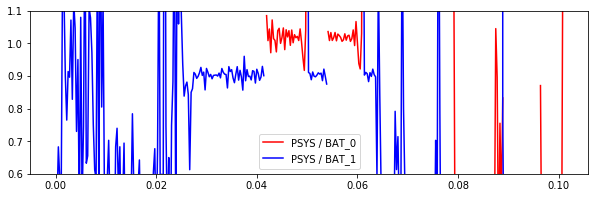

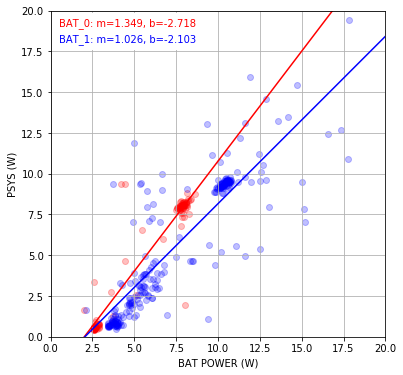

In [8]:
## PSYS versus BAT_POWER
fig,ax=plt.subplots(1,1,figsize=(10,3),facecolor='white')

ax.plot(t, sys_w/p0, c='r', label='PSYS / BAT_0')
ax.legend(facecolor='white')
ax.grid()
ax.set_ylim([0.6,1.1])

if DUAL_BAT:
    ax.plot(t, sys_w/p1, c='b', label='PSYS / BAT_1')
    ax.legend(facecolor='white')
    ax.grid()
    ax.set_ylim([0.6,1.1])

fig,ax=plt.subplots(1,1,figsize=(6,6),facecolor='white')
x = np.linspace(0,20,num=10)

filt=1
sys_w_ = np.array(sys_w[p0>filt])
p0_ = np.array(p0[p0>filt])

ax.scatter(p0_,sys_w_,color='r', label='BAT0', alpha=0.25)
z0 = np.polyfit(p0_,sys_w_,1)
y0 = np.poly1d(z0)
ax.plot(x,y0(x),'r')
ax.text(0.5,19.1,"BAT_0: m={:.3f}, b={:.3f}".format(z0[0],z0[1]),
        color='r', backgroundcolor='white')
ax.set_xlabel('TIME (HOUR)')

if DUAL_BAT:
    sys_w_ = np.array(sys_w[p1>filt])
    p1_ = np.array(p1[p1>filt])
    ax.scatter(p1_,sys_w_,color='b', label='BAT1', alpha=0.25)
    z1 = np.polyfit(p1_,sys_w_,1)
    y1 = np.poly1d(z1)
    ax.plot(x,y1(x),'b')
    ax.text(0.5,18.1,"BAT_1: m={:.3f}, b={:.3f}".format(z1[0],z1[1]),
            color='b', backgroundcolor='white')

ax.axis([0,20,0,20])
ax.set_xlabel('BAT POWER (W)')
ax.set_ylabel('PSYS (W)')
ax.grid()

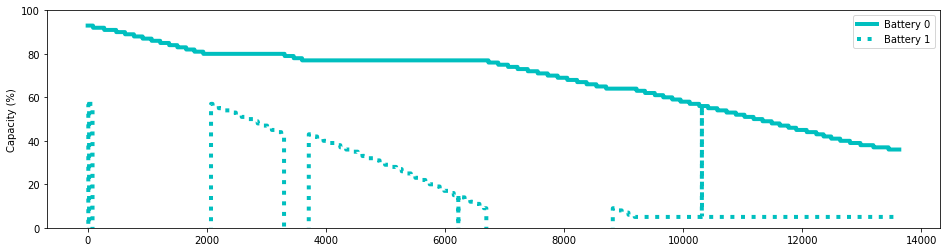

In [58]:
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(df["c0"], 'c', lw=4, label='Battery 0')
ax.plot(df["c1"], 'c:', lw=4, label='Battery 1')
ax.set_ylim([0,100])
ax.set_ylabel('Capacity (%)');
ax.legend()